In [1]:
import os, random, json
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm

import torch
import torch.nn as nn
from torchvision import models, transforms
from torchvision.utils import make_grid
from PIL import Image


In [2]:
DATA_DIR = r"C:\Users\manav\Documents\dataset_roi_gt"
META_PATH = os.path.join(DATA_DIR, "slices_roi_metadata.csv")

df = pd.read_csv(META_PATH)
print(f"Total slices: {len(df)}")
print(df.head())


Total slices: 19879
                patient  split  slice grade                 bbox  \
0  BraTS20_Training_229  train     83   HGG  [57, 109, 126, 157]   
1  BraTS20_Training_229  train     84   HGG  [56, 104, 127, 159]   
2  BraTS20_Training_229  train     85   HGG  [55, 103, 128, 159]   
3  BraTS20_Training_229  train     86   HGG  [54, 103, 135, 161]   
4  BraTS20_Training_229  train     87   HGG  [54, 101, 140, 162]   

   mask_area_pct  mean_intensity  \
0         0.5764          0.4091   
1         1.0920          0.4234   
2         1.4288          0.4419   
3         1.8420          0.4555   
4         2.1753          0.4660   

                                                path  
0  C:\Users\manav\Documents\dataset_roi_gt\train\...  
1  C:\Users\manav\Documents\dataset_roi_gt\train\...  
2  C:\Users\manav\Documents\dataset_roi_gt\train\...  
3  C:\Users\manav\Documents\dataset_roi_gt\train\...  
4  C:\Users\manav\Documents\dataset_roi_gt\train\...  


grade
HGG    17997
LGG     1882
Name: count, dtype: int64
grade
HGG    3.151262
LGG    3.171788
Name: mask_area_pct, dtype: float64


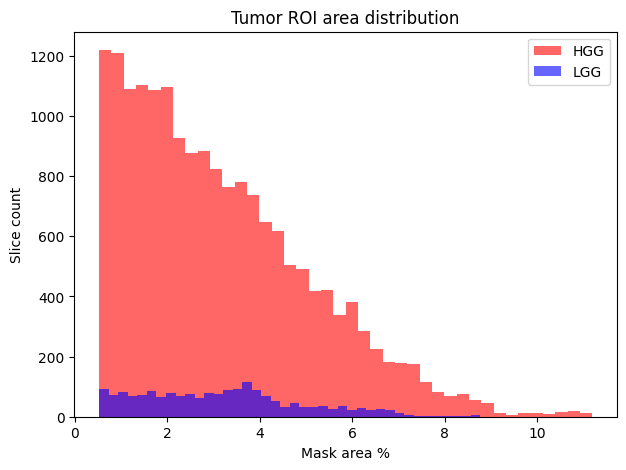

In [3]:
print(df['grade'].value_counts())
print(df.groupby('grade')['mask_area_pct'].mean())

plt.figure(figsize=(7,5))
for grade, color in zip(["HGG","LGG"], ["r","b"]):
    plt.hist(df[df.grade==grade]['mask_area_pct'], bins=40, alpha=0.6, label=grade, color=color)
plt.title("Tumor ROI area distribution")
plt.xlabel("Mask area %")
plt.ylabel("Slice count")
plt.legend()
plt.show()


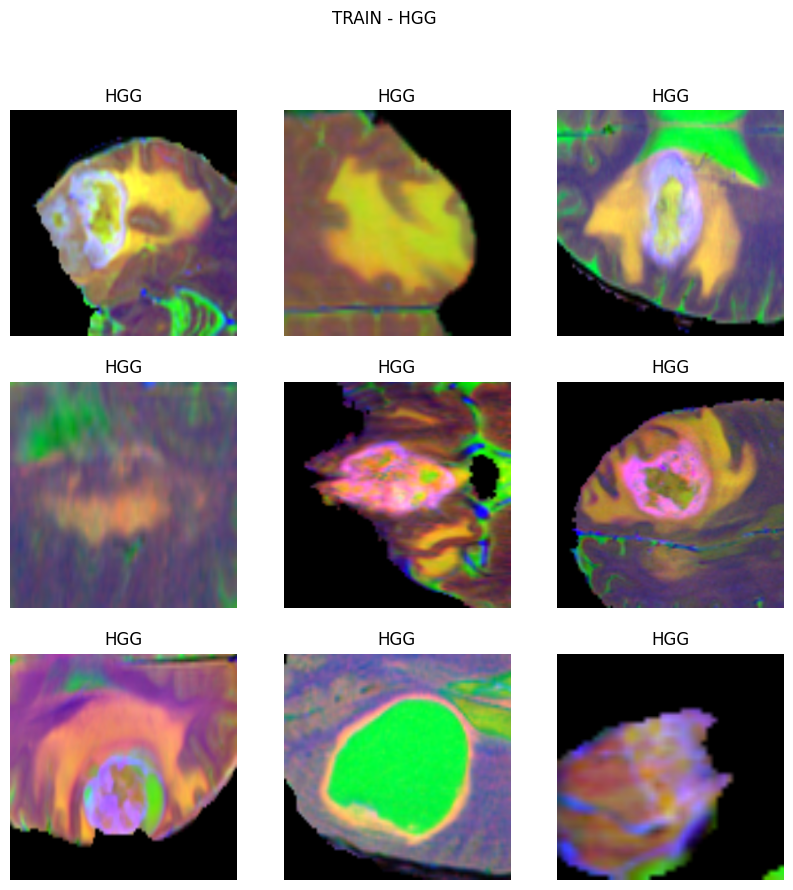

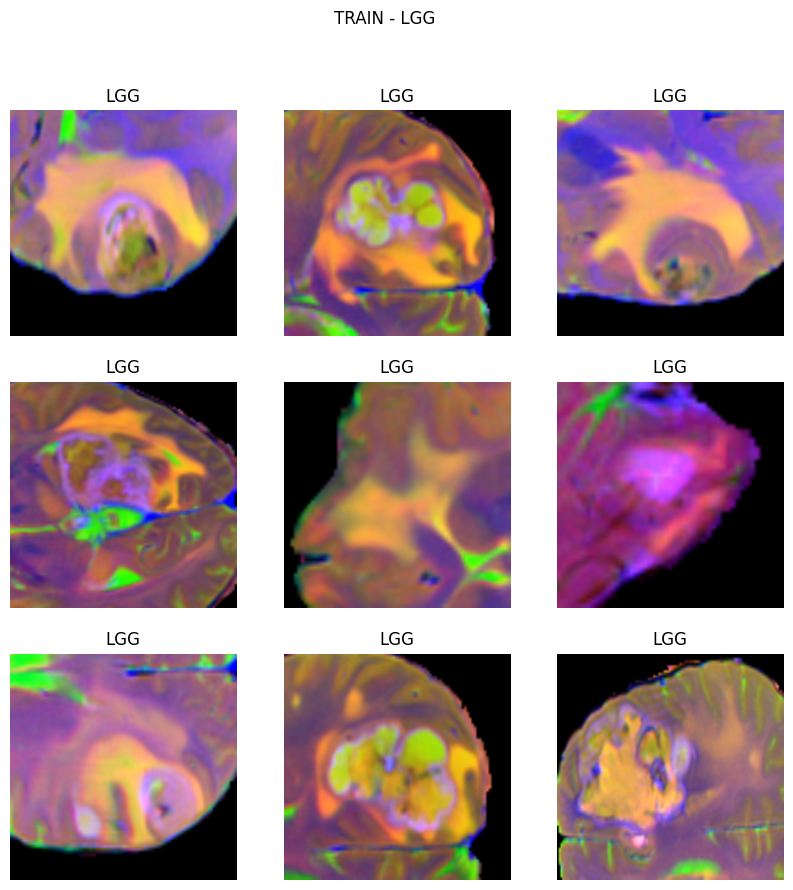

In [4]:
def show_random_images(split="train", grade="HGG", n=9):
    img_dir = Path(DATA_DIR) / split / grade
    paths = list(img_dir.glob("*.png"))
    imgs = random.sample(paths, min(n, len(paths)))
    
    plt.figure(figsize=(10,10))
    for i, p in enumerate(imgs):
        img = cv2.imread(str(p))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(3,3,i+1)
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"{grade}")
    plt.suptitle(f"{split.upper()} - {grade}")
    plt.show()

show_random_images("train", "HGG")
show_random_images("train", "LGG")


c:\Users\manav\miniconda3\envs\efficientnet\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\manav\miniconda3\envs\efficientnet\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\Users\manav\miniconda3\envs\efficientnet\lib\site-packages\torch\nn\modules\module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backwa

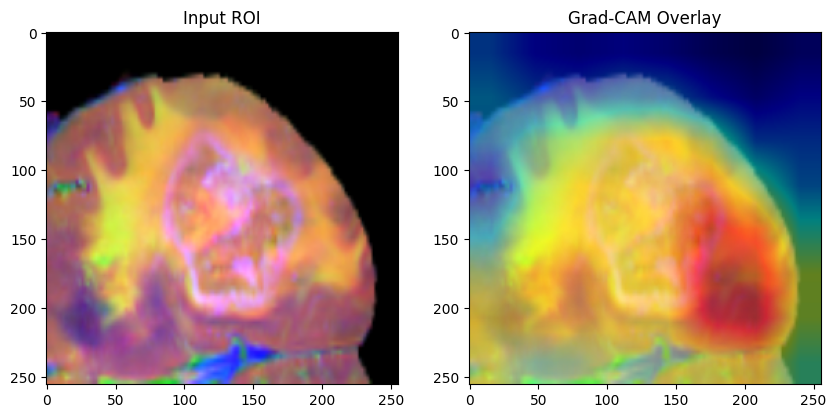

In [5]:
from torchvision.models import efficientnet_b0
from torch.nn import functional as F

# Load pretrained EfficientNetB0
model = efficientnet_b0(pretrained=True).eval().cuda()

# Select target layer for Grad-CAM
target_layer = model.features[-1][0]

# Grad-CAM helper
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.gradients = None
        target_layer.register_forward_hook(self.save_activation)
        target_layer.register_backward_hook(self.save_gradient)
        self.activation = None
        
    def save_activation(self, module, input, output):
        self.activation = output
        
    def save_gradient(self, module, grad_in, grad_out):
        self.gradients = grad_out[0]
        
    def generate(self, input_tensor, target_class=None):
        output = self.model(input_tensor)
        if target_class is None:
            target_class = output.argmax(dim=1)
        self.model.zero_grad()
        output[0, target_class].backward()
        weights = self.gradients.mean(dim=(2, 3), keepdim=True)
        cam = (weights * self.activation).sum(dim=1, keepdim=True)
        cam = F.relu(cam)
        cam = cam[0, 0].cpu().detach().numpy()
        cam = cv2.resize(cam, (input_tensor.shape[2], input_tensor.shape[3]))
        cam = (cam - cam.min()) / (cam.max() - cam.min())
        return cam

# Transform for EfficientNet input
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Run Grad-CAM on random image
img_path = random.choice(list(Path(DATA_DIR, "train", "HGG").glob("*.png")))
img = cv2.imread(str(img_path))
rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
inp = transform(Image.fromarray(rgb)).unsqueeze(0).cuda()

cam_engine = GradCAM(model, target_layer)
cam = cam_engine.generate(inp)

# Overlay
heatmap = cv2.applyColorMap(np.uint8(255*cam), cv2.COLORMAP_JET)
overlay = cv2.addWeighted(cv2.cvtColor(rgb, cv2.COLOR_RGB2BGR), 0.5, heatmap, 0.5, 0)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(rgb); plt.title("Input ROI")
plt.subplot(1,2,2); plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB)); plt.title("Grad-CAM Overlay")
plt.show()
